 ARIMA and Seasonal ARIMA
    Autoregressive Integrated Moving Averages
    The general process for ARIMA models is the following:

  Visualize the Time Series Data
    Make the time series data stationary
    Plot the Correlation and AutoCorrelation Charts
    Construct the ARIMA Model or Seasonal ARIMA based on the data
    Use the model to make predictions
    Let's go through these steps!

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df=pd.read_csv('C:\\Users\\91897\\Downloads\\sales_1.csv')
print(df.shape)
df.head()

(913000, 6)


,date,store,item,sales,f0,f1
0,01-01-2013,1,1,13.0,9.0,NaN
1,02-01-2013,1,1,11.0,NaN,NaN
2,03-01-2013,1,1,14.0,NaN,NaN
3,04-01-2013,1,1,13.0,NaN,NaN
4,05-01-2013,1,1,10.0,NaN,NaN


### Data Cleaning

In [3]:
df.drop(columns=['f0','f1'],axis=1,inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    913000 non-null  object 
 1   store   913000 non-null  int64  
 2   item    913000 non-null  int64  
 3   sales   912943 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.9+ MB


In [5]:
df['date']=df['date'].astype('datetime64[ns]')

C:\Users\91897\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '13-01-2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\91897\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '14-01-2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\91897\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '15-01-2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\91897\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '16-01-2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\91897\anaconda3\lib\site-packages\pandas\core\d

In [6]:
df.isnull().sum()

date      0
store     0
item      0
sales    57
dtype: int64

### Filling null values in sales column:

In [7]:
df=df.set_index('date')
df=df.interpolate()


In [8]:
print(df.isnull().sum())
df=df.reset_index(drop=False)
df

store    0
item     0
sales    0
dtype: int64


,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-02-01,1,1,11.0
2,2013-03-01,1,1,14.0
3,2013-04-01,1,1,13.0
4,2013-05-01,1,1,10.0
...,...,...,...,...
912995,2017-12-27,10,50,63.0
912996,2017-12-28,10,50,59.0
912997,2017-12-29,10,50,74.0
912998,2017-12-30,10,50,62.0


### Data Preprocessing

   For the purpose we are taking only values of 'store 1' and its'item 1'.
    New features will be added too.
    
   Data Will be splitted into trainand test from:
    -Train Dataset consist of values from January 2013 to September 2017
    -Test Dataset consist of values from  October 2017 to December 2017

In [9]:
# sort the values by date
df.sort_values(by='date',ascending=True,inplace=True)

In [10]:
# Filter the data of 'Store 1' and its 'item 1'
df=df[df['store']==1]
df=df[df['item']==1]

# Converting date into  datetime object
df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d')

# Creating new features onn the basis of date
df['Year']=df['date'].dt.year
df['Month']=df['date'].dt.month
df['Day']=df['date'].dt.day
df['Weekday']=df['date'].dt.weekday
df['Weekday']=np.where(df['Weekday']==0,7,df['Weekday'])

In [11]:
df.head(5)

,date,store,item,sales,Year,Month,Day,Weekday
0,2013-01-01,1,1,13.0,2013,1,1,1
31,2013-01-02,1,1,11.0,2013,1,2,2
59,2013-01-03,1,1,15.0,2013,1,3,3
90,2013-01-04,1,1,11.0,2013,1,4,4
120,2013-01-05,1,1,16.0,2013,1,5,5


In [12]:
# Splitting the data into train and test as mentioned above:

temp=df.set_index('date')
train_df=temp.loc[:'2017-09-30'].reset_index(drop=False)
test_df=temp.loc['2017-10-01':].reset_index(drop=False)

In [13]:
train_df

,date,store,item,sales,Year,Month,Day,Weekday
0,2013-01-01,1,1,13.0,2013,1,1,1
1,2013-01-02,1,1,11.0,2013,1,2,2
2,2013-01-03,1,1,15.0,2013,1,3,3
3,2013-01-04,1,1,11.0,2013,1,4,4
4,2013-01-05,1,1,16.0,2013,1,5,5
...,...,...,...,...,...,...,...,...
1729,2017-09-26,1,1,18.0,2017,9,26,1
1730,2017-09-27,1,1,27.0,2017,9,27,2
1731,2017-09-28,1,1,23.0,2017,9,28,3
1732,2017-09-29,1,1,28.0,2017,9,29,4


In [14]:
test_df

,date,store,item,sales,Year,Month,Day,Weekday
0,2017-10-01,1,1,11.000000,2017,10,1,6
1,2017-10-02,1,1,16.000000,2017,10,2,7
2,2017-10-03,1,1,18.000000,2017,10,3,1
3,2017-10-04,1,1,19.000000,2017,10,4,2
4,2017-10-05,1,1,17.000000,2017,10,5,3
...,...,...,...,...,...,...,...,...
87,2017-12-27,1,1,14.000000,2017,12,27,2
88,2017-12-28,1,1,19.000000,2017,12,28,3
89,2017-12-29,1,1,20.333333,2017,12,29,4
90,2017-12-30,1,1,21.666667,2017,12,30,5


## Data Exploration

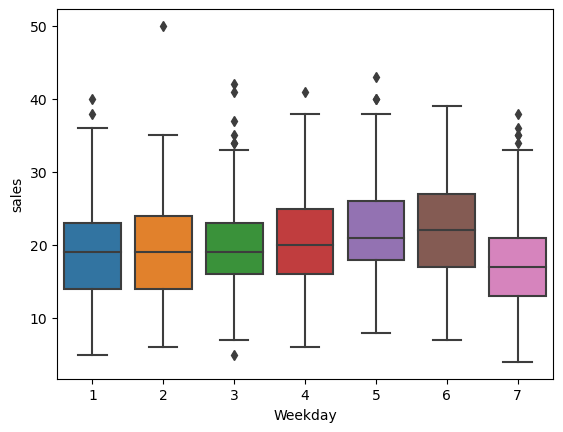

In [15]:
sns.boxplot(x=df['Weekday'],y=df.sales)
plt.show()

   From the graph it shows sales gradually increase from Monday to Saturday(Peak) while drastically falls on Sunday

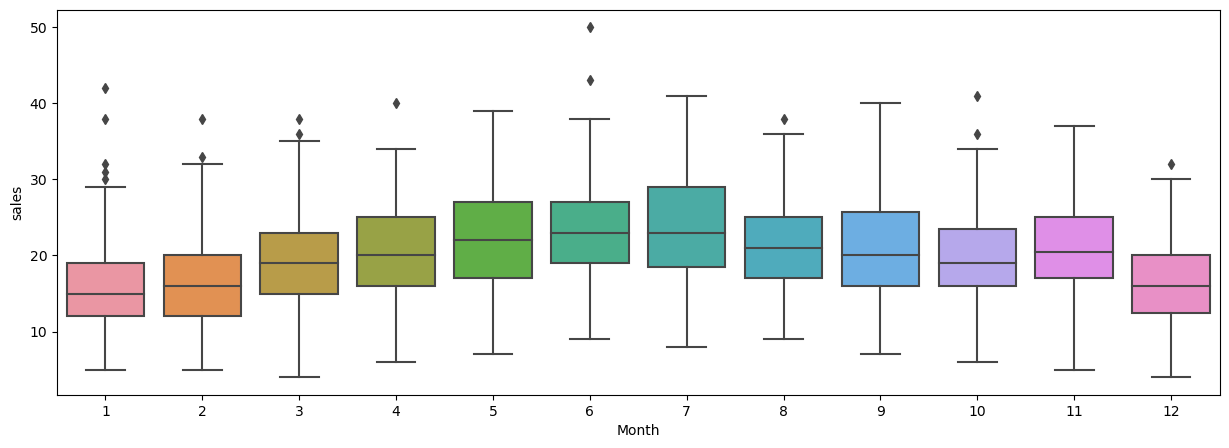

In [16]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df.Month,y=df.sales)
plt.show()

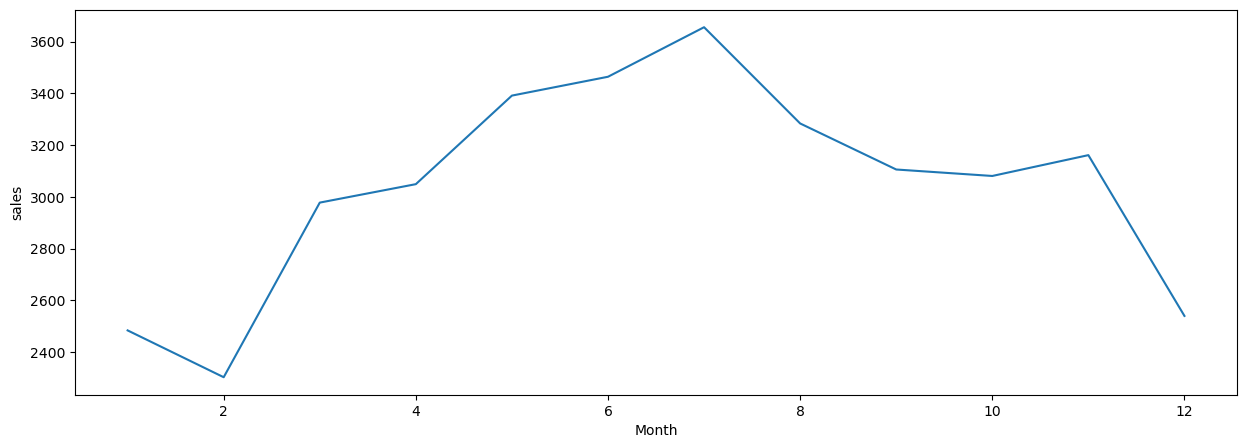

In [17]:
month=df.groupby('Month')['sales'].sum().reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(x=month['Month'],y=month['sales'])
plt.show()

   Sales gradually increases from Feb(2) to July(7) which is the peak and then decreases again unpt November(11) 
     then again decreases to December(12) - January(1)

<AxesSubplot:xlabel='Year', ylabel='sales'>

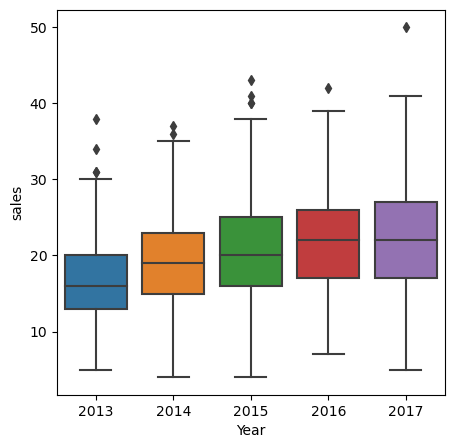

In [18]:
plt.figure(figsize=(5,5))
sns.boxplot(x=df.Year,y=df.sales)

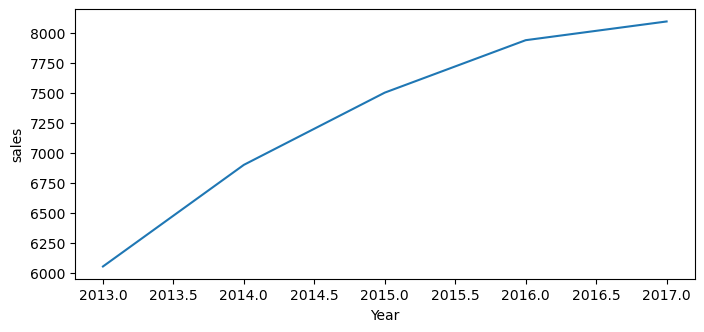

In [19]:
year=df.groupby('Year')['sales'].sum().reset_index()

plt.figure(figsize=(8,3.5))
sns.lineplot(x=year.Year,y=year.sales)
plt.show()

   Clearly evident that sales keeps on increasing year by year.
    Starting at 6000 in 2013 to 8000 in 2017---> SALES increase by 33% in 5 year

<AxesSubplot:xlabel='date', ylabel='sales'>

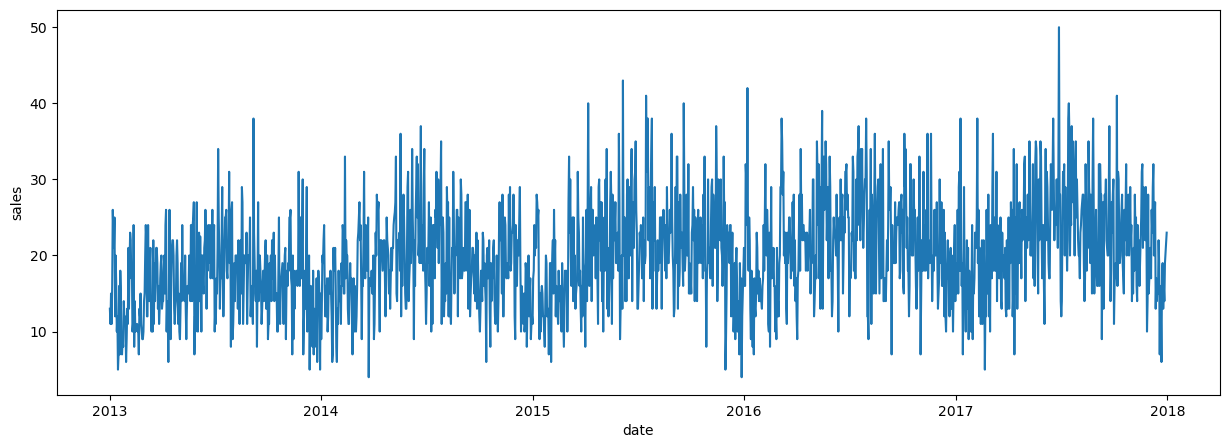

In [20]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df['date'],y=df['sales'])

In [21]:
df

,date,store,item,sales,Year,Month,Day,Weekday
0,2013-01-01,1,1,13.000000,2013,1,1,1
31,2013-01-02,1,1,11.000000,2013,1,2,2
59,2013-01-03,1,1,15.000000,2013,1,3,3
90,2013-01-04,1,1,11.000000,2013,1,4,4
120,2013-01-05,1,1,16.000000,2013,1,5,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14.000000,2017,12,27,2
1822,2017-12-28,1,1,19.000000,2017,12,28,3
1823,2017-12-29,1,1,20.333333,2017,12,29,4
1824,2017-12-30,1,1,21.666667,2017,12,30,5


## Forcasting


##### 1. Linear Regression

In [22]:
reg_df=df
reg_df

,date,store,item,sales,Year,Month,Day,Weekday
0,2013-01-01,1,1,13.000000,2013,1,1,1
31,2013-01-02,1,1,11.000000,2013,1,2,2
59,2013-01-03,1,1,15.000000,2013,1,3,3
90,2013-01-04,1,1,11.000000,2013,1,4,4
120,2013-01-05,1,1,16.000000,2013,1,5,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14.000000,2017,12,27,2
1822,2017-12-28,1,1,19.000000,2017,12,28,3
1823,2017-12-29,1,1,20.333333,2017,12,29,4
1824,2017-12-30,1,1,21.666667,2017,12,30,5


###### Feature Engineering

In [23]:
for i in range(0,8):
    reg_df['lag_'+str(i)]=reg_df.sales.shift(i)


In [24]:
reg_df.head(15)

,date,store,item,sales,Year,Month,Day,Weekday,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,2013-01-01,1,1,13.0,2013,1,1,1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,2013-01-02,1,1,11.0,2013,1,2,2,11.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
59,2013-01-03,1,1,15.0,2013,1,3,3,15.0,11.0,13.0,NaN,NaN,NaN,NaN,NaN
90,2013-01-04,1,1,11.0,2013,1,4,4,11.0,15.0,11.0,13.0,NaN,NaN,NaN,NaN
120,2013-01-05,1,1,16.0,2013,1,5,5,16.0,11.0,15.0,11.0,13.0,NaN,NaN,NaN
151,2013-01-06,1,1,26.0,2013,1,6,6,26.0,16.0,11.0,15.0,11.0,13.0,NaN,NaN
181,2013-01-07,1,1,23.0,2013,1,7,7,23.0,26.0,16.0,11.0,15.0,11.0,13.0,NaN
212,2013-01-08,1,1,21.0,2013,1,8,1,21.0,23.0,26.0,16.0,11.0,15.0,11.0,13.0
243,2013-01-09,1,1,25.0,2013,1,9,2,25.0,21.0,23.0,26.0,16.0,11.0,15.0,11.0
273,2013-01-10,1,1,12.0,2013,1,10,3,12.0,25.0,21.0,23.0,26.0,16.0,11.0,15.0


In [25]:
reg_df['rolling_mean']=reg_df['sales'].rolling(window=7).mean()
reg_df['rolling_max']=reg_df['sales'].rolling(window=7).max()
reg_df['rolling_min']=reg_df['sales'].rolling(window=7).min()

In [26]:
reg_df.dropna(inplace=True)
reg_df.drop(columns=['store','item'],inplace=True)
reg_df.set_index('date',inplace=True)

In [27]:
reg_df_train=reg_df.loc[:'2017-09-30']
reg_df_train

,sales,Year,Month,Day,Weekday,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_max,rolling_min
date,,,,,,,,,,,,,,,,
2013-01-08,21.0,2013,1,8,1,21.0,23.0,26.0,16.0,11.0,15.0,11.0,13.0,17.571429,26.0,11.0
2013-01-09,25.0,2013,1,9,2,25.0,21.0,23.0,26.0,16.0,11.0,15.0,11.0,19.571429,26.0,11.0
2013-01-10,12.0,2013,1,10,3,12.0,25.0,21.0,23.0,26.0,16.0,11.0,15.0,19.142857,26.0,11.0
2013-01-11,20.0,2013,1,11,4,20.0,12.0,25.0,21.0,23.0,26.0,16.0,11.0,20.428571,26.0,12.0
2013-01-12,16.0,2013,1,12,5,16.0,20.0,12.0,25.0,21.0,23.0,26.0,16.0,20.428571,26.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-26,18.0,2017,9,26,1,18.0,14.0,24.0,37.0,28.0,20.0,20.0,21.0,23.000000,37.0,14.0
2017-09-27,27.0,2017,9,27,2,27.0,18.0,14.0,24.0,37.0,28.0,20.0,20.0,24.000000,37.0,14.0
2017-09-28,23.0,2017,9,28,3,23.0,27.0,18.0,14.0,24.0,37.0,28.0,20.0,24.428571,37.0,14.0


In [28]:
reg_df_test=reg_df.loc['2017-10-01':]
reg_df_test

,sales,Year,Month,Day,Weekday,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_max,rolling_min
date,,,,,,,,,,,,,,,,
2017-10-01,11.000000,2017,10,1,6,11.000000,30.000000,28.000000,23.0,27.0,18.0,14.0,24.0,21.571429,30.000000,11.0
2017-10-02,16.000000,2017,10,2,7,16.000000,11.000000,30.000000,28.0,23.0,27.0,18.0,14.0,21.857143,30.000000,11.0
2017-10-03,18.000000,2017,10,3,1,18.000000,16.000000,11.000000,30.0,28.0,23.0,27.0,18.0,21.857143,30.000000,11.0
2017-10-04,19.000000,2017,10,4,2,19.000000,18.000000,16.000000,11.0,30.0,28.0,23.0,27.0,20.714286,30.000000,11.0
2017-10-05,17.000000,2017,10,5,3,17.000000,19.000000,18.000000,16.0,11.0,30.0,28.0,23.0,19.857143,30.000000,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,14.000000,2017,12,27,2,14.000000,16.000000,13.000000,19.0,18.0,6.0,12.0,16.0,14.000000,19.000000,6.0
2017-12-28,19.000000,2017,12,28,3,19.000000,14.000000,16.000000,13.0,19.0,18.0,6.0,12.0,15.000000,19.000000,6.0
2017-12-29,20.333333,2017,12,29,4,20.333333,19.000000,14.000000,16.0,13.0,19.0,18.0,6.0,17.047619,20.333333,13.0


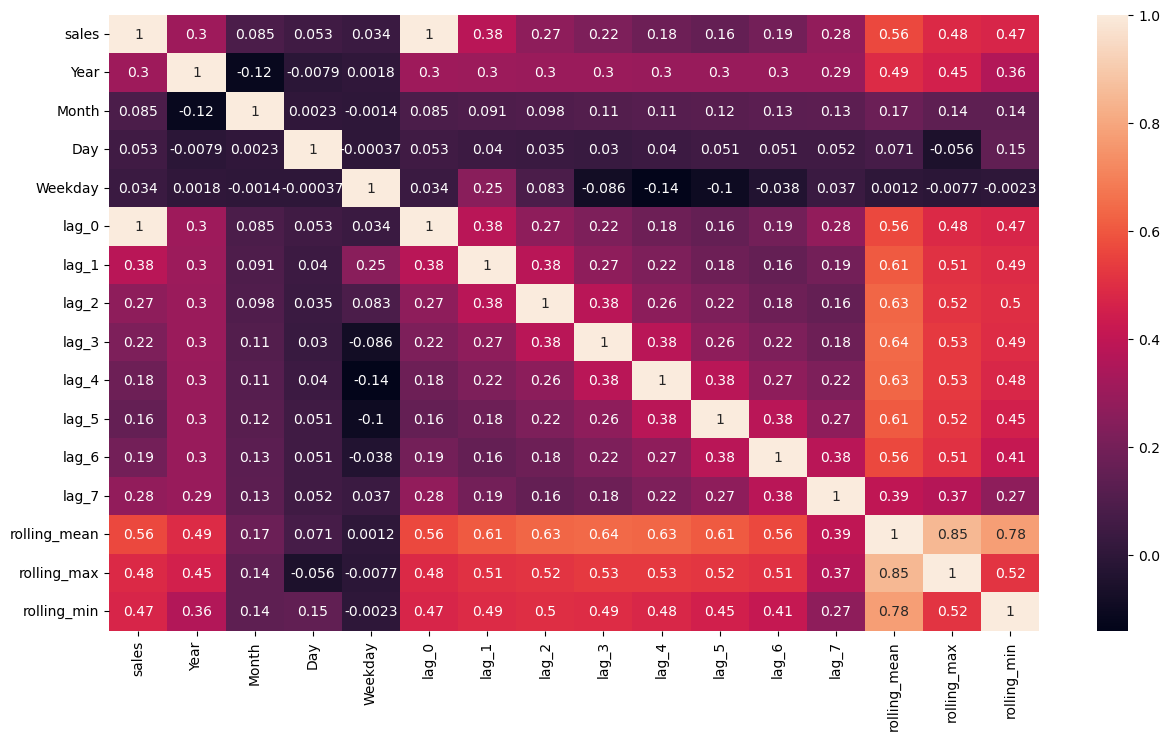

In [29]:
plt.figure(figsize=(15,8))
sns.heatmap(reg_df_train.corr(),annot=True)
plt.show()

In [30]:
x_train=reg_df_train.drop(['sales'],axis=1)
y_train=reg_df_train['sales']

x_test=reg_df_test.drop(['sales'],axis=1)
y_test=reg_df_test['sales']

In [31]:
# Selecting Best Features for our model

top_features=SelectKBest(score_func=f_regression,k=5)
fit=top_features.fit(x_train,y_train)
df_scores=pd.DataFrame(fit.scores_)
df_scores

,0
0,1.765972e+02
1,1.250283e+01
2,4.821641e+00
3,1.943899e+00
4,1.553742e+18
5,2.892446e+02
6,1.316514e+02
7,9.051123e+01
8,5.728236e+01
9,4.296611e+01


In [32]:
df_columns=pd.DataFrame(x_train.columns)
column_score=pd.concat([df_columns,df_scores],axis=1)
column_score

,0,0
0,Year,1.765972e+02
1,Month,1.250283e+01
2,Day,4.821641e+00
3,Weekday,1.943899e+00
4,lag_0,1.553742e+18
5,lag_1,2.892446e+02
6,lag_2,1.316514e+02
7,lag_3,9.051123e+01
8,lag_4,5.728236e+01
9,lag_5,4.296611e+01


In [33]:
# Now we gonna select top 7 best performance feaures
# But we gonna select only 5

column_score.columns=['Features','score']
print(column_score.nlargest(7,'score'))

        Features         score
4          lag_0  1.553742e+18
12  rolling_mean  8.063174e+02
13   rolling_max  5.267879e+02
14   rolling_min  4.992277e+02
5          lag_1  2.892446e+02
0           Year  1.765972e+02
11         lag_7  1.429989e+02


[Text(0.5, 1.0, 'Linear relationship between sales and lag 1')]

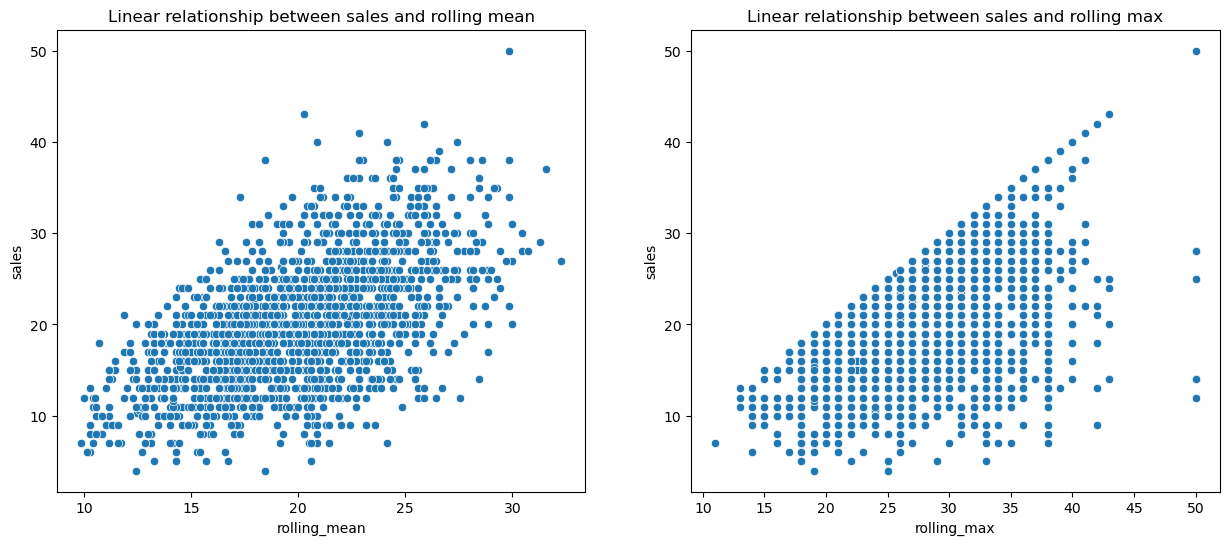

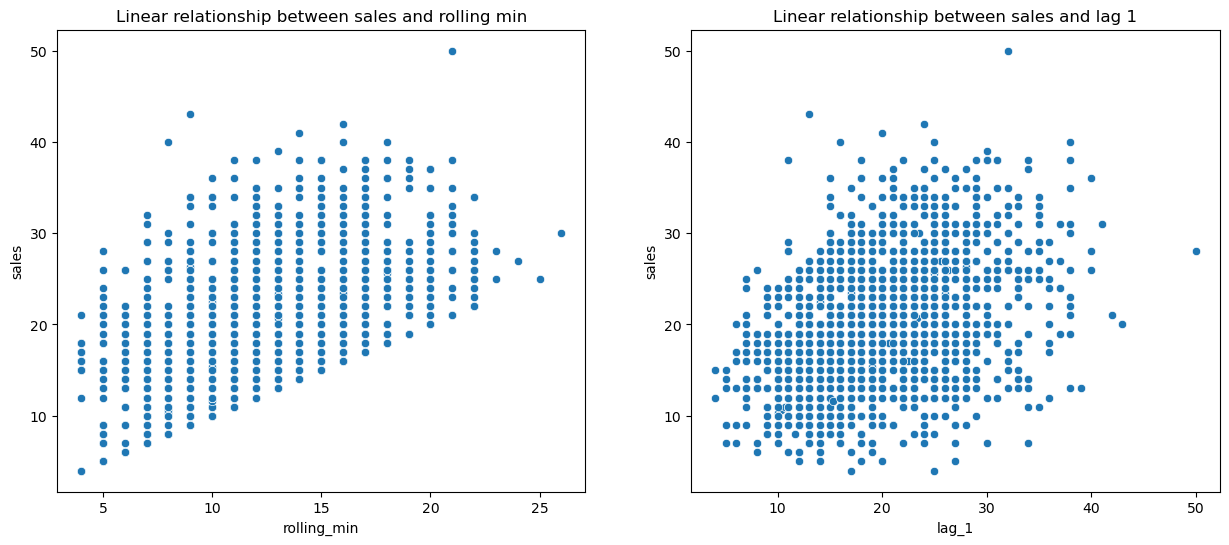

In [34]:
fig,ax=plt.subplots(ncols=2,figsize=(15,6))

sns.scatterplot(x=reg_df_train['rolling_mean'],y=reg_df_train['sales'],ax=ax[0])
ax[0].set(title='Linear relationship between sales and rolling mean')
sns.scatterplot(x=reg_df_train['rolling_max'],y=reg_df_train['sales'],ax=ax[1])
ax[1].set(title='Linear relationship between sales and rolling max')

fig,ax=plt.subplots(ncols=2,figsize=(15,6))

sns.scatterplot(x=reg_df_train['rolling_min'],y=reg_df_train['sales'],ax=ax[0])
ax[0].set(title='Linear relationship between sales and rolling min')
sns.scatterplot(x=reg_df_train['lag_1'],y=reg_df_train['sales'],ax=ax[1])
ax[1].set(title='Linear relationship between sales and lag 1')

In [35]:
# as we have already many features including all isn't ok,so we gonna put top 5 features

x_train=x_train[['rolling_mean','rolling_max','rolling_min','lag_1','lag_7']]
x_test=x_test[['rolling_mean','rolling_max','rolling_min','lag_1','lag_7']]

# fit model
model=LinearRegression()
model.fit(x_train,y_train)

preds=model.predict(x_test)


error_df=reg_df_test[['sales']]
error_df['pred_sales']=preds
error_df['error']=preds-y_test # Depicts Error by margin
error_df.insert(0, 'model', 'LinearRegression')
error_df

C:\Users\91897\AppData\Local\Temp\ipykernel_9000\2286275301.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['pred_sales']=preds
C:\Users\91897\AppData\Local\Temp\ipykernel_9000\2286275301.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['error']=preds-y_test # Depicts Error by margin


,model,sales,pred_sales,error
date,,,,
2017-10-01,LinearRegression,11.000000,21.616505,10.616505
2017-10-02,LinearRegression,16.000000,19.950796,3.950796
2017-10-03,LinearRegression,18.000000,20.527541,2.527541
2017-10-04,LinearRegression,19.000000,20.623397,1.623397
2017-10-05,LinearRegression,17.000000,19.915007,2.915007
...,...,...,...,...
2017-12-27,LinearRegression,14.000000,14.011809,0.011809
2017-12-28,LinearRegression,19.000000,14.183603,-4.816397
2017-12-29,LinearRegression,20.333333,16.764842,-3.568491


### Model Evaluation and Prediction

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


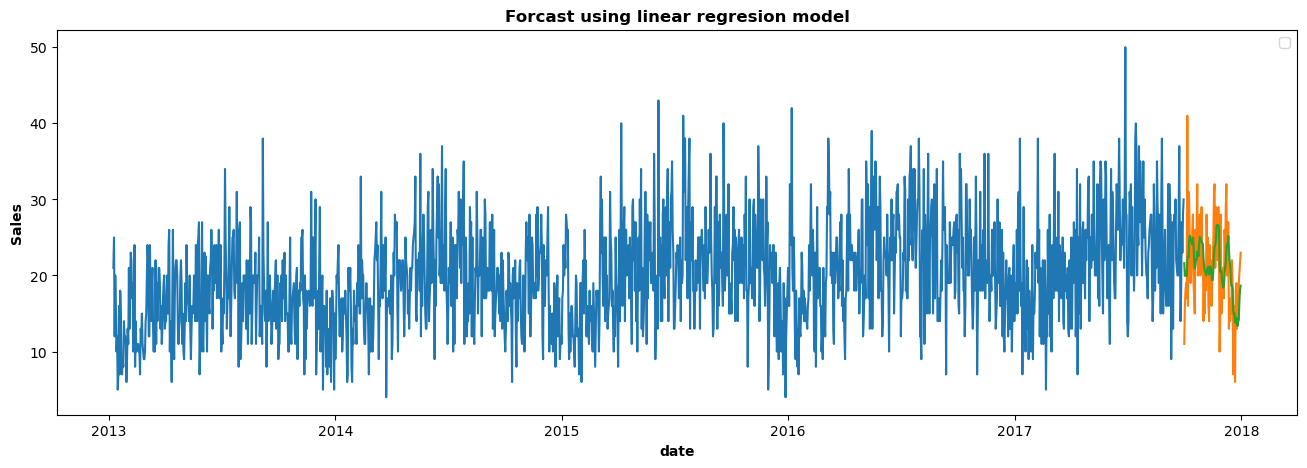

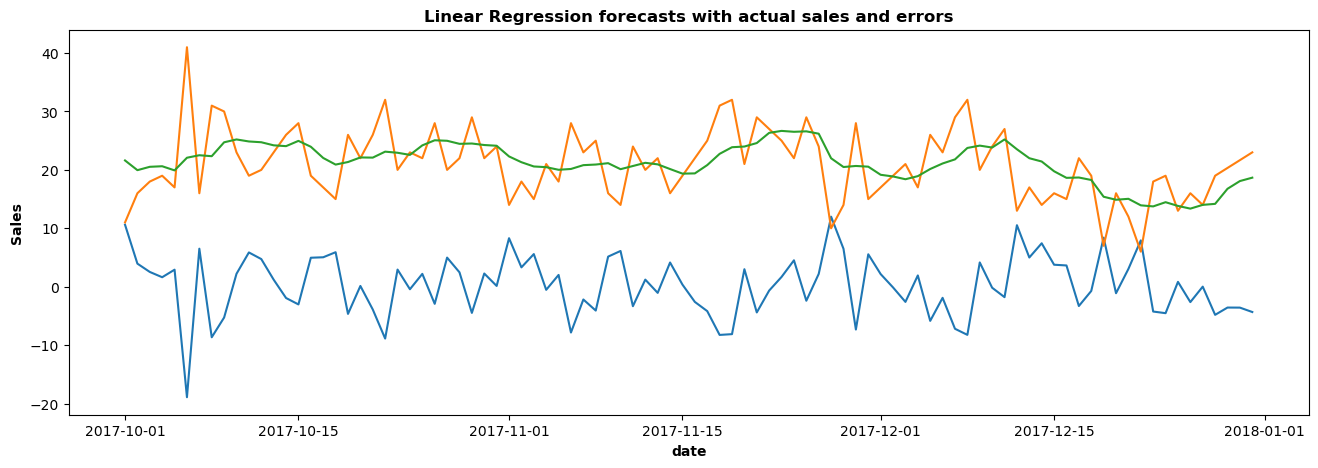

In [36]:
plt.figure(figsize=(16,5))
plt.plot(reg_df_train.index,reg_df_train.sales)
plt.plot(reg_df_test.index,reg_df_test.sales)
plt.plot(error_df.index,error_df.pred_sales)
plt.legend(loc='best')
plt.xlabel('date',fontweight='bold')
plt.ylabel('Sales',fontweight='bold')
plt.title('Forcast using linear regresion model',fontweight='bold')
plt.show()


plt.figure(figsize=(16,5))
plt.plot(error_df.index,error_df.error)
plt.plot(error_df.index,error_df.sales)
plt.plot(error_df.index,error_df.pred_sales)
#plt.legend(loc='best')
plt.xlabel('date',fontweight='bold')
plt.ylabel('Sales',fontweight='bold')

plt.title('Linear Regression forecasts with actual sales and errors',fontweight='bold')
plt.show()

# ARIMA and SARIMAX Model

#### 1. Checking the Stationarity of Time Series

   Here we going to use 3 methods for checking the stationarity:
   1. Plotting rolling statistics: By Checking Rolling Mean and Rolling Variance
     
   2. Augmented Dickey-Fuller Test:The test statistic is expected to be negative; therefore, it has to
       be more negative(less) than the critical value for the hypothesis to be rejected and conclude that 
       series is stationary.
      
   3.ACF and PACF plots:An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of 
       itself. A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a 
       lag of itself that is not explained by correlations at all lower-order lags.

In [37]:
arima_train_df=train_df[['date','sales']].set_index('date')
arima_test_df=test_df[['date','sales']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean=timeseries.rolling(window=365).mean()
    rollstd=timeseries.rolling(window=365).std()
    
    plt.figure(figsize=(15,5))
    plt.plot(timeseries,color='green',label='original Series')
    plt.plot(rollmean,color='black',label='Roliing Mean')
    plt.plot(rollstd,color='red',label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()
    
    # Augmented Adfuller test
    adfuller_test=adfuller(timeseries,autolag='AIC')
    print('Test Statistic {:.3f}'.format(adfuller_test[0]))
    print('P-Value {:.3f}'.format(adfuller_test[1]))
    print('Critical Values:')
    
    
    for key,value in adfuller_test[4].items():
        print('\t{}:{} - The data is {} stationary with {}% of confidence'.format(key,value,
                                        '' if adfuller_test[0]<value else 'not',100-int(key[:-1])))
    
    # Autocorrelation plot
    fig,ax=plt.subplots(nrows=2,figsize=(14,7))
    ax[0]=plot_acf(timeseries,ax=ax[0],lags=20)
    ax[1]=plot_pacf(timeseries,ax=ax[1],lags=20)

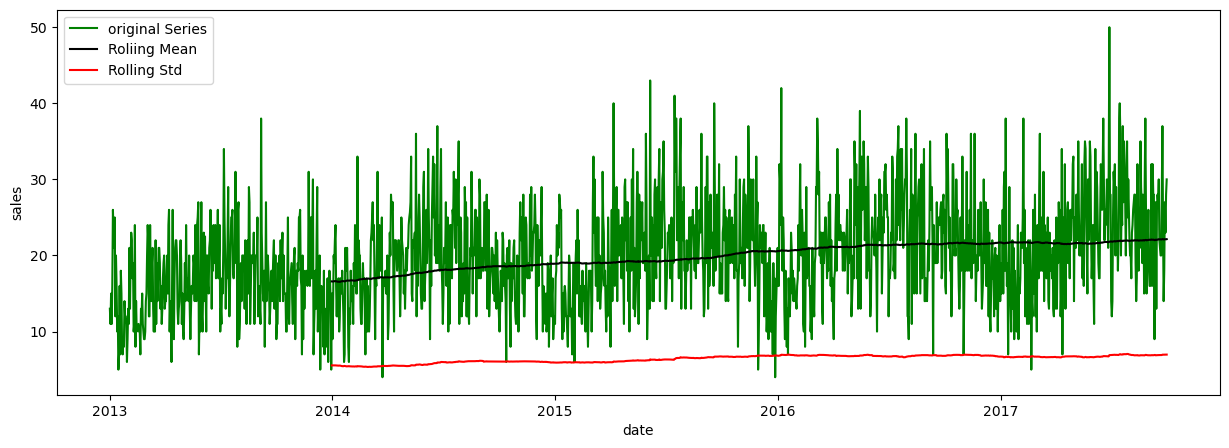

Test Statistic -4.640
P-Value 0.000
Critical Values:
	1%:-3.434177666727206 - The data is  stationary with 99% of confidence
	5%:-2.8632307003234203 - The data is  stationary with 95% of confidence
	10%:-2.5676700828345895 - The data is  stationary with 90% of confidence


C:\Users\91897\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


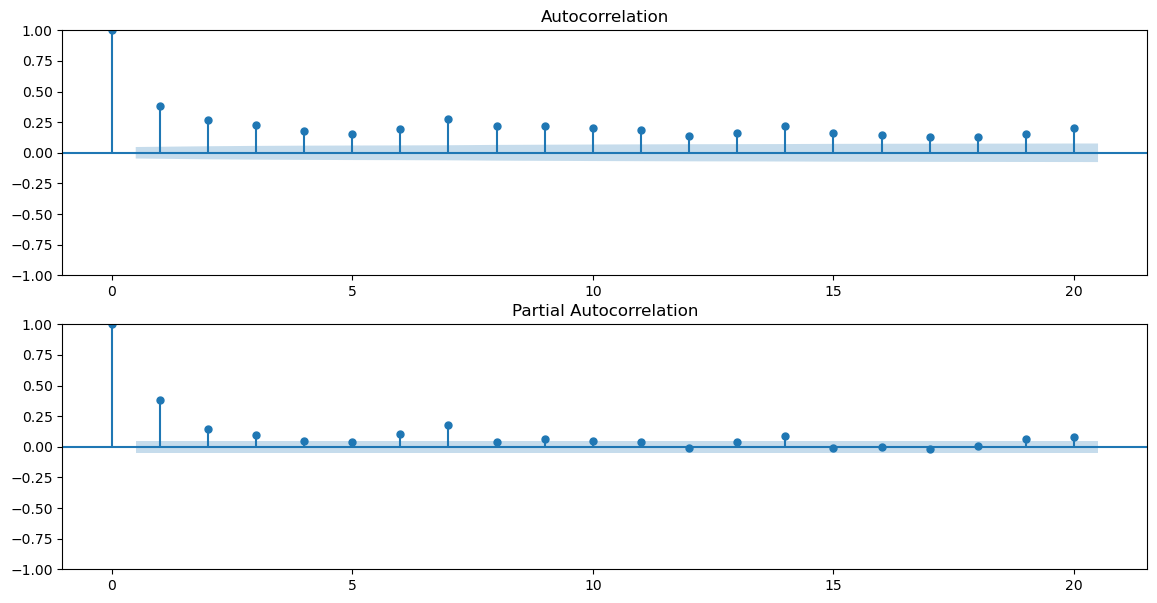

In [38]:
test_stationarity(arima_train_df.sales)

    Looking at the results from our test, we can conclude that the series is not stationary. Therefore, in order to 
    make the series stationary we apply Differencing

### Differencing

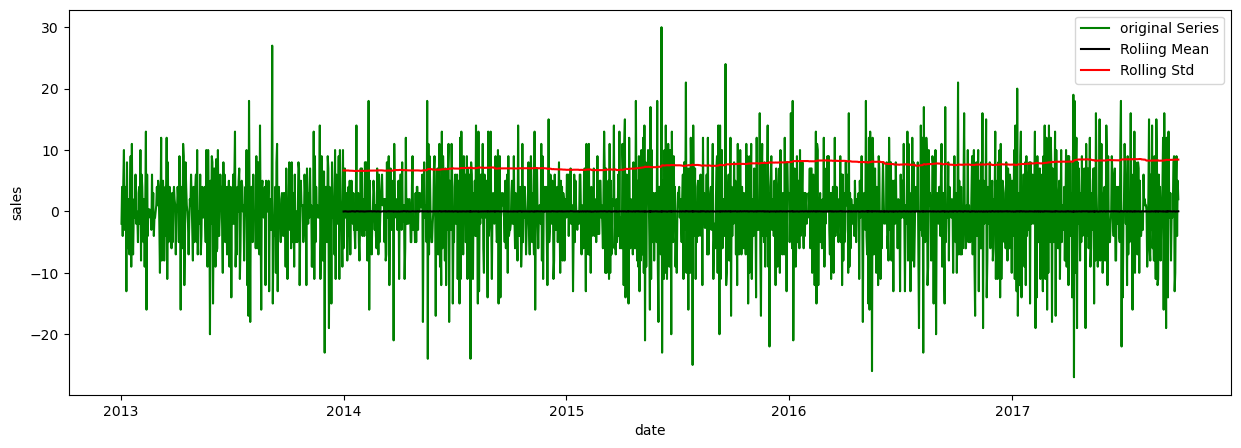

Test Statistic -13.661
P-Value 0.000
Critical Values:
	1%:-3.4341866496114535 - The data is  stationary with 99% of confidence
	5%:-2.8632346655630943 - The data is  stationary with 95% of confidence
	10%:-2.567672194245481 - The data is  stationary with 90% of confidence


C:\Users\91897\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


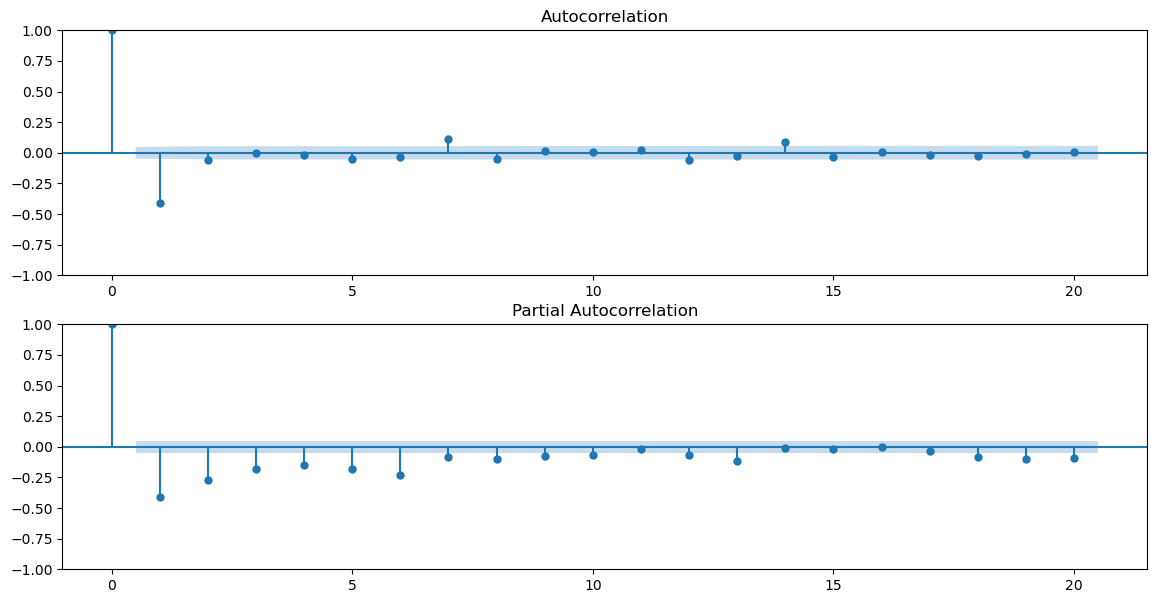

In [39]:
first_diff=arima_train_df['sales']-arima_train_df['sales'].shift(1)
first_diff=pd.DataFrame(first_diff.dropna(inplace=False))

test_stationarity(first_diff)

    After applying Differencing now we can observe the data is stationary because both the values i.e mean and
    variance are constant over the time.

### Step 3 Model Building

##### Interpreting the AR(p),  I(d),  MA(q) values:

##### 1.Determing I (d):
    aking the first order difference makes the time series stationary. Therefore, I(d) = 1.
##### 2. Determining AR(p):
    If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, 
    then choose a AR order of 1.

        From the PACF plot we can clearly observe that within 6 lags the AR is significant. Therefore, we 
        can use AR(p) = 6, (6 lines are crossed the blue lines so 6past days are required to predict).
##### 3. Determining Ma(q):
    If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then 
    choose a MA order of 1.

    From tha ACF plot we see a negative spike at lag 1, therfore we can use MA(q) = 1


In [40]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model=ARIMA(arima_train_df['sales'],order=(6,1,1))
arima_fit=arima_model.fit()
print(arima_fit.summary())

C:\Users\91897\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\91897\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\91897\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1734
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5556.476
Date:                Tue, 16 Jan 2024   AIC                          11128.951
Time:                        19:24:08   BIC                          11172.612
Sample:                    01-01-2013   HQIC                         11145.099
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2058      0.025      8.125      0.000       0.156       0.255
ar.L2          0.0293      0.025      1.180      0.238      -0.019       0.078
ar.L3          0.0077      0.025      0.312      0.7

### Plotting the residuals using Acf and Pacf

C:\Users\91897\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\91897\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\91897\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\91897\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


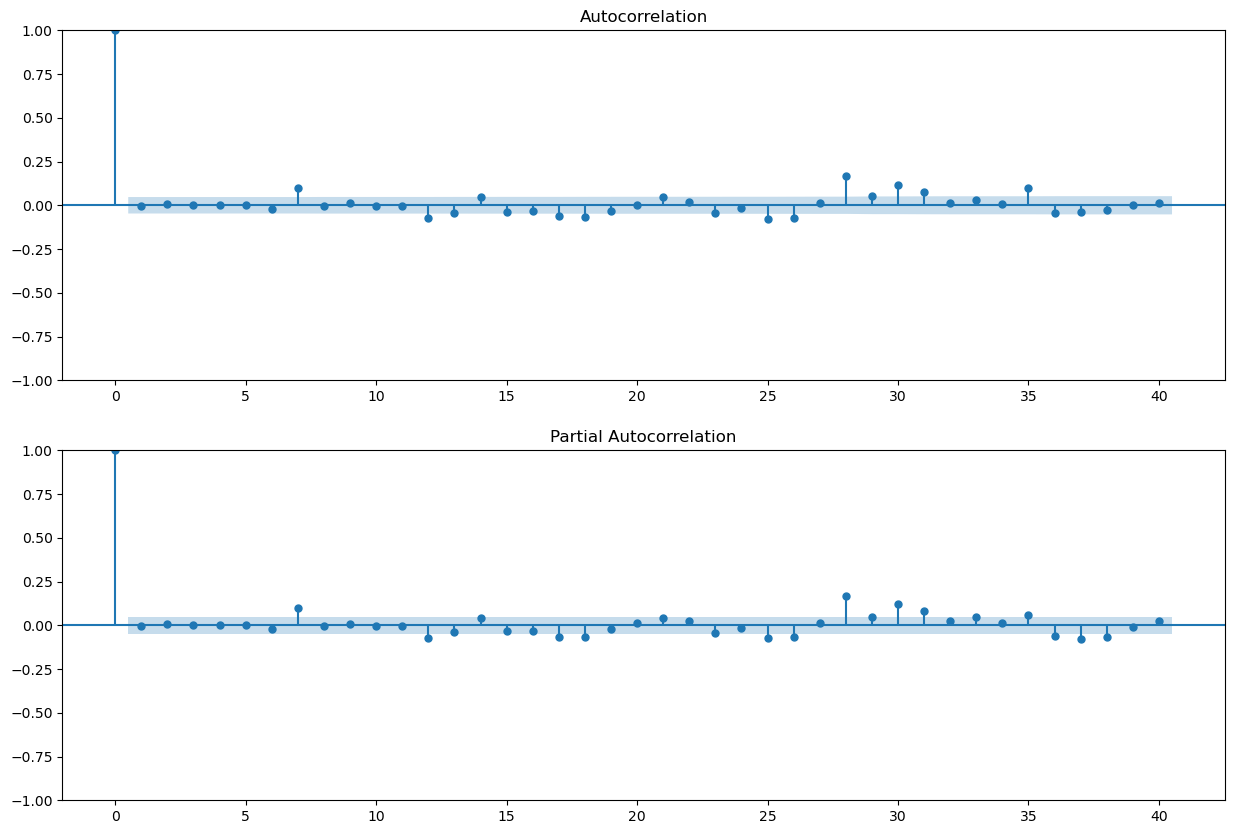

In [41]:
arima=ARIMA(arima_train_df['sales'],order=(6,1,1))
fit=arima.fit()
residual=fit.resid


fig,ax=plt.subplots(nrows=2,figsize=(15,10))
ax[0]=plot_acf(residual,ax=ax[0],lags=40)
ax[1]=plot_pacf(residual,ax=ax[1],lags=40)

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

SARIMA is Seasonal ARIMA, or simply put, ARIMA with a seasonal component

The parameters for these types of models are as follows:

p and seasonal P: indicate the number of AR terms (lags of the stationary series)

d and seasonal D: indicate differencing that must be done to stationary series

q and seasonal Q: indicate the number of MA terms (lags of the forecast errors)

C:\Users\91897\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\91897\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


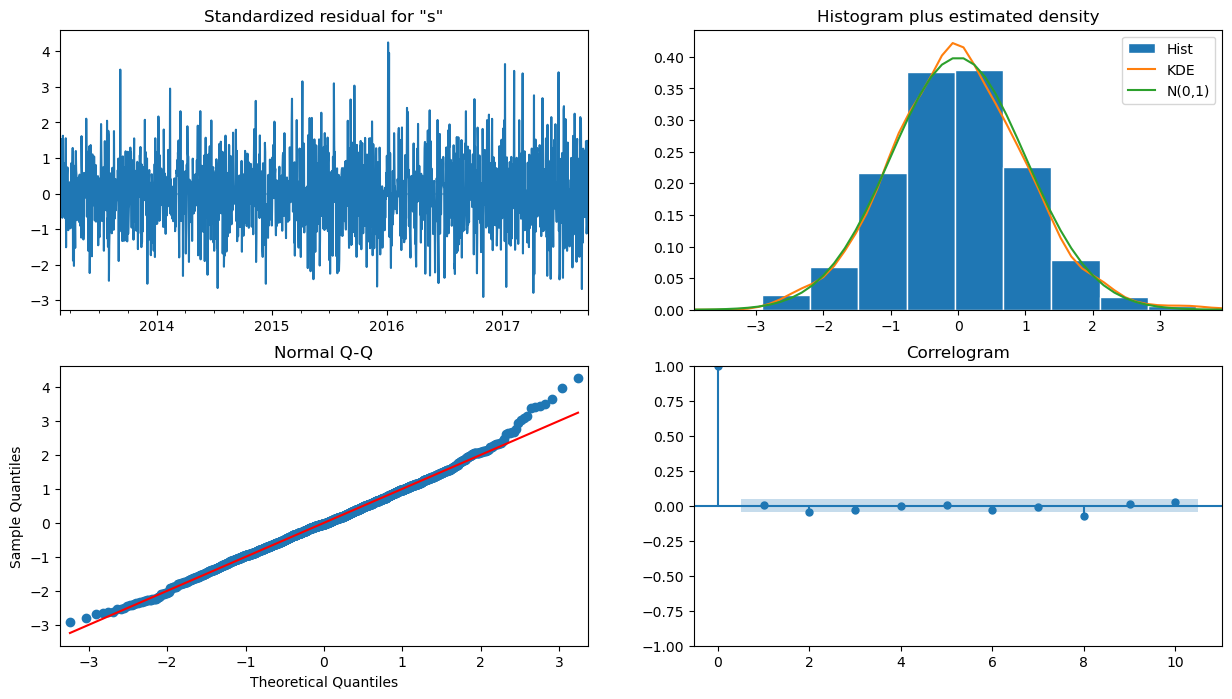

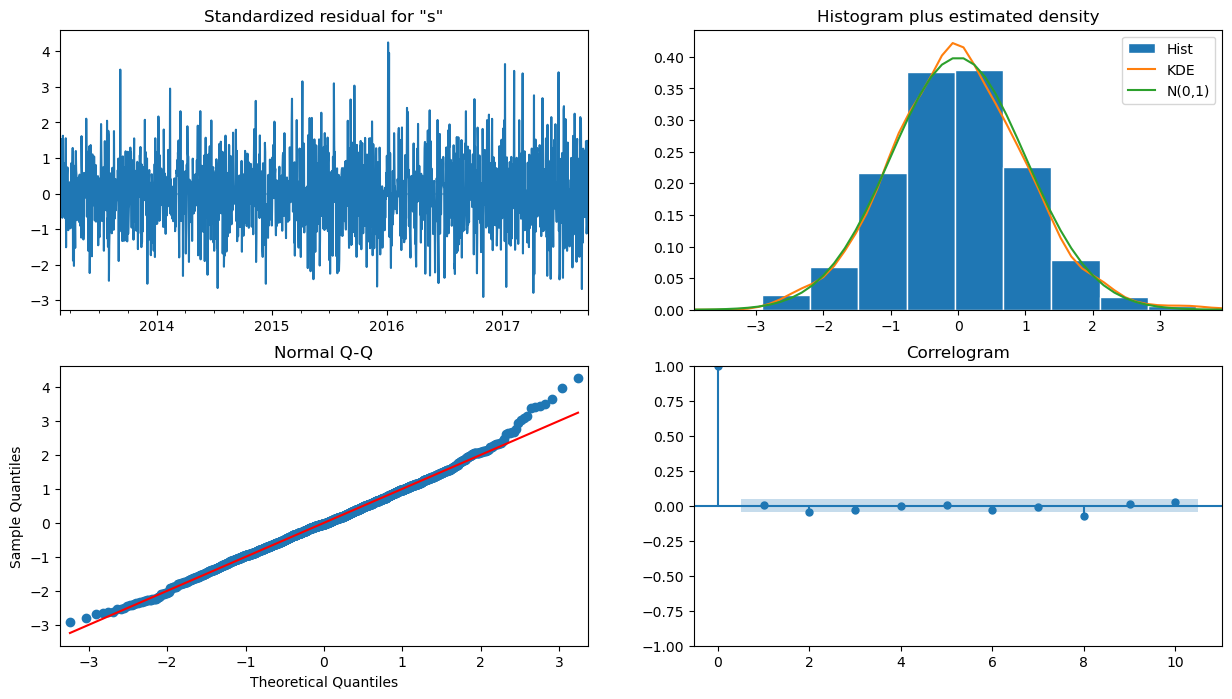

In [42]:
sarima_model=SARIMAX(arima_train_df['sales'],order=(6,1,0),seasonal_order=(6,1,0,7),
                    enforce_stationarity=False, enforce_invertibility=False)
sarima_fit=sarima_model.fit()

arima_test_df['pred_sales']=sarima_fit.predict(start=arima_test_df.index[0],end=arima_test_df.index[-1],dynamic=True)

plot=sarima_fit.plot_diagnostics(figsize=(15,8))
plot

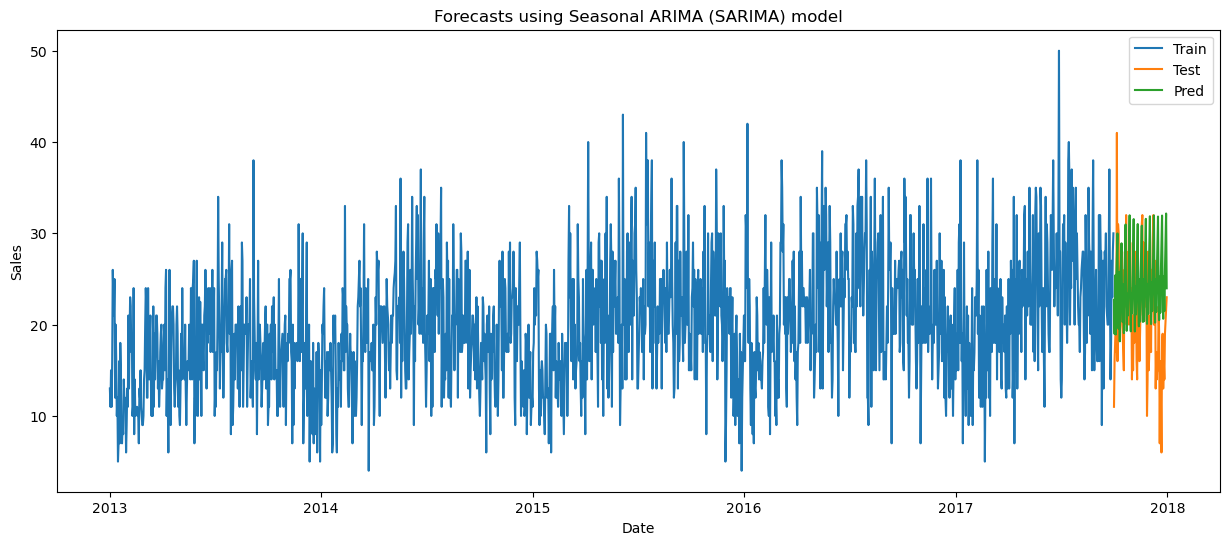

In [43]:
# eval
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales
arima_test_df.insert(0, 'model', 'SARIMA')

# Plotting
plt.figure(figsize=(15,6))
plt.plot(arima_train_df.index,arima_train_df['sales'],label='Train')
plt.plot(arima_test_df.index,arima_test_df['sales'],label='Test')
plt.plot(arima_test_df.index,arima_test_df['pred_sales'],label='Pred')
plt.legend(loc='best')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

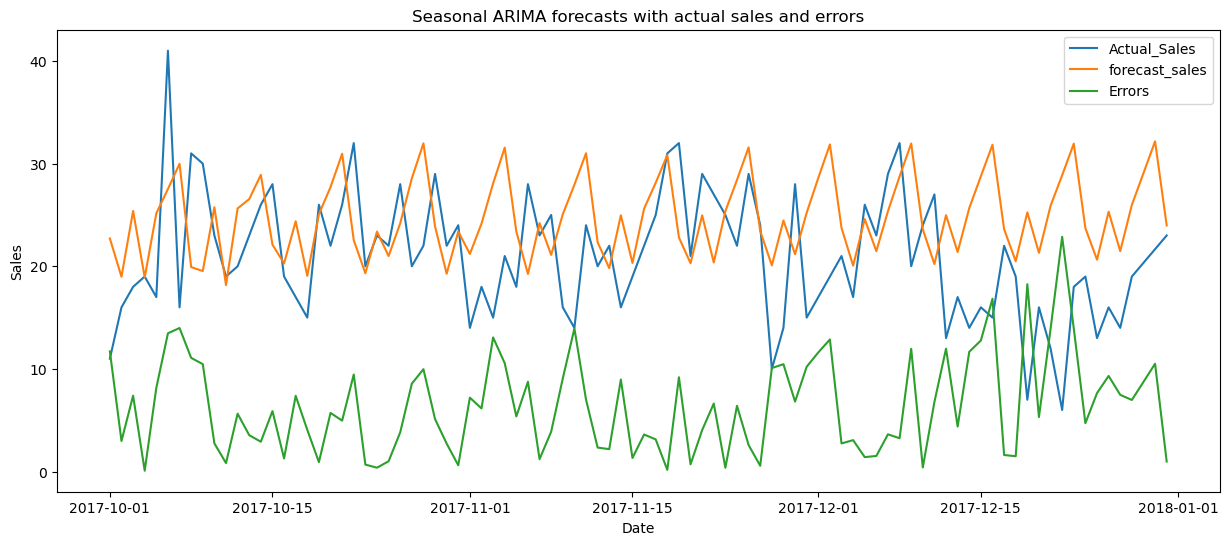

In [44]:
plt.figure(figsize=(15,6))
plt.plot(arima_test_df.index,arima_test_df['sales'],label='Actual_Sales')
plt.plot(arima_test_df.index,arima_test_df['pred_sales'],label='forecast_sales')
plt.plot(arima_test_df.index,np.abs(arima_test_df['errors']),label='Errors')
plt.legend(loc='best')
plt.title('Seasonal ARIMA forecasts with actual sales and errors')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

## Conclusion

  We considered different time-series models as well as a regression model for time series forecasting. From our results
  we saw that the linear regression model outperformed the other time-series models. Therefore, for this dataset we 
  could use a regression model, rather than a time-series model to forecast sales. 